In [6]:
from path import Path
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import cv2

import numpy as np
import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = "tight"

## 实例分割转目标检测

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
maskpath=Path(r'D:\nn\code\datasets\fire\satellite\Segments\A2023001_h11v07.png')

mask=read_image(maskpath)
img=read_image(maskpath)

obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]
print(masks.size())
print(masks)

In [53]:

# drawn_masks = []
# for mask in masks:
#     drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

# show(drawn_masks)

In [54]:
boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)

torch.Size([1, 4])
tensor([[1508.,  398., 3453., 1478.]])


In [ ]:
drawn_boxes = draw_bounding_boxes((1-img)*255, boxes, colors="red")
show(drawn_boxes)
show(img*255)

## 语义分割转目标检测

In [8]:
from skimage import morphology,measure

def getboundingbox(imdata:np.array):
    # mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    # mask[np.where(image == rgbmask[1])] = 1
    mask=imdata>0
    # 删掉小于100像素的目标
    mask_without_small = morphology.remove_small_objects(mask,min_size=100,connectivity=2)
    # 连通域标记
    label_image = measure.label(mask_without_small,connectivity=2)
    #统计object个数
    regionprops= measure.regionprops(label_image)
    boundingbox = [region.bbox for region in regionprops]
    return boundingbox

In [9]:
def newgetboundingbox(imdata:np.array):
    # 通过膨胀去连通，可以min_size筛除小目标,或者通过锚框面积筛除
    # 通过kernel调整膨胀
    ## 膨胀
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (150,150))
    dilated = cv2.dilate(imdata.copy(), kernel, 1)
    # plt.imshow(dilated)
    bboxs = getboundingbox(dilated)
    # print(bboxs)
    ## 细化锚框
    tbboxs =getboundingbox(imdata)
    # print(tbboxs)
    cluster=[]
    for bbox in bboxs:
        tmp=[]
        for tbbox in tbboxs:
            if tbbox[0]>=bbox[0] and tbbox[1]>=bbox[1] and tbbox[2]<=bbox[2] and tbbox[3]<=bbox[3]:
                tmp.append(tbbox)
        cluster.append(tmp)

    res=[]
    for i in cluster:
        # print(i)
        xy=list(zip(*i))
        if xy:
            res.append([min(xy[0]),min(xy[1]),max(xy[2]),max(xy[3])])
    return res

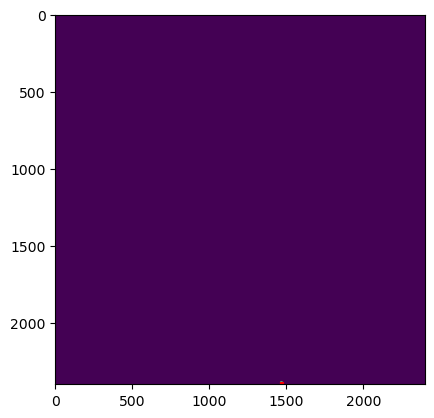

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patch

maskpath=Path(r'D:\nn\code\datasets\fire\satellite\Segments\A2023001_h11v07.png')
im=cv2.imread(maskpath,0)

res=newgetboundingbox(im)

# 考虑DBSCAN是否可以实现
fig,ax = plt.subplots(1)
ax.imshow(im)
for box in res:
    rect = patch.Rectangle((box[1], box[0]), box[3]-box[1], box[2]-box[0],edgecolor = 'r', linewidth = 1,fill = False)
    ax.add_patch(rect)

## 生成标注文件

In [11]:
import xml.etree.ElementTree as ET

def createXMLlabel(savedir,objectnum, bbox, classname=None, foldername='0',filename='0', path='0', database='road', width='400', height='600',depth='3', segmented='0', pose="Unspecified", truncated='0', difficult='0'):
    # 创建根节点
    root = ET.Element("annotation")
 
    # 创建子节点
    folder_node = ET.Element("folder")
    folder_node.text = foldername
    # 将子节点数据添加到根节点
    root.append(folder_node)
 
    file_node = ET.Element("filename")
    file_node.text = filename
    root.append(file_node)
    path_node = ET.Element("path")
    path_node.text = path
    root.append(path_node)
 
    source_node = ET.Element("source")
    # 也可以使用SubElement直接添加子节点
    db_node = ET.SubElement(source_node, "database")
    db_node.text = database
    root.append(source_node)
 
    size_node = ET.Element("size")
    width_node = ET.SubElement(size_node, "width")
    height_node = ET.SubElement(size_node, "height")
    depth_node = ET.SubElement(size_node, "depth")
    width_node.text = str(width)
    height_node.text = str(height)
    depth_node.text = str(depth)
    root.append(size_node)
 
    seg_node = ET.Element("segmented")
    seg_node.text = segmented
    root.append(seg_node)
    
    for i in range(objectnum):
        newEle = ET.Element("object")
        name = ET.Element("name")
        if classname:
            name.text = classname
        else:
            name.text=bbox[i][4]
        newEle.append(name)
        pose_node = ET.Element("pose")
        pose_node.text = pose
        newEle.append(pose_node)
        trunc = ET.Element("truncated")
        trunc.text = truncated
        newEle.append(trunc)
        dif = ET.Element("difficult")
        dif.text = difficult
        newEle.append(dif)
        boundingbox = ET.Element("bndbox")
        xmin = ET.SubElement(boundingbox, "xmin")
        ymin = ET.SubElement(boundingbox, "ymin")
        xmax = ET.SubElement(boundingbox, "xmax")
        ymax = ET.SubElement(boundingbox, "ymax")
        xmin.text = str(int(bbox[i][1]))
        ymin.text = str(int(bbox[i][0]))
        xmax.text = str(int(bbox[i][3]))
        ymax.text = str(int(bbox[i][2]))
        newEle.append(boundingbox)
        root.append(newEle)
 
    ImageID = filename.split('.')[0]
    # 创建elementtree对象，写入文件
    tree = ET.ElementTree(root)
    tree.write(savedir + '/'+ ImageID + ".xml")
 

In [12]:
images=Path(r'D:\nn\code\datasets\fire\satellite\JPEGImages')
masks=Path(r'D:\nn\code\datasets\fire\satellite\Segments')
annos = Path(r'D:\nn\code\datasets\fire\satellite\Annotations')
if not annos.exists():
    annos.mkdir()
for f in images.files():
    
    maskpath=masks/f'{f.stem}.png'
    mask = cv2.imread(maskpath,0)
    bbox = newgetboundingbox(mask)

    objectnum = len(bbox)
    image_name = f.name

    height,width = mask.shape

    foldername = 'JPEGImages'
    impath  = f
    database = 'Unknown'
    depth = '3'
    classname='fire'
    
    createXMLlabel(annos,objectnum, bbox, classname, foldername=foldername,filename=image_name, path=impath,
                    database=database, width=width, height=height,depth=depth, segmented='0', pose="Unspecified",
                    truncated='0', difficult='0')